# SUBMITTED  BY :-
 ><h2>Sampark Pradhan</h2>
 ><h2>B00821733</h2>

In [2]:
# Importing Required Libraries

import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from pprint import pprint
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import re
from nltk.corpus import stopwords
from nltk.tag import pos_tag
import xml.etree.ElementTree as et
import os
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import KFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
%matplotlib inline
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

Using TensorFlow backend.


## 1) Loading the data using assignment one dataset.

In [3]:
# Function to extract the xml data to a dataframe

def create_dataframe():
    df_cols = ["headline", "text", "bip_topics", "date_published", "itemid", "filename"]
    rows = []
    for root, dirs, files in os.walk('.\Data'):
        for file in files:
            if(file.endswith('.xml')):
                xtree = et.parse(os.path.join(root,file))
                xroot = xtree.getroot()
                text = ""
                dc_date = ""
                bip_topics = []
                itemid= ""
                xmlFileName = ""
                txt = ""
            
                headline = xroot.find('headline').text
            
                for texts in xroot.find('text'):
                    text = et.tostring(texts)
                    txt = txt + text.decode("utf-8")
                    
                for metadata in xroot.iter('metadata'):
                    for dc in metadata.iter('dc'):
                        if dc.attrib.get('element') == 'dc.date.published':
                            dc_date = dc.attrib.get('value')
            
                for metadata in xroot.iter('metadata'):
                    for bip in metadata.iter('codes'):
                        if bip.attrib.get('class') == 'bip:topics:1.0': 
                            for cd in bip.iter('code'):
                                bip_topics.append(cd.attrib.get('code'))
                            
                itemid = xroot.attrib.get("itemid")
                xmlFileName = file
            
                rows.append({"headline": headline, "text": txt, "bip_topics": bip_topics, "date_published": dc_date,"itemid":
                         itemid,"filename":xmlFileName})

    my_df = pd.DataFrame(rows, columns = df_cols)
    
    return my_df

# Calling the function create_dataframe and showing the head of dataframe.
df = create_dataframe()
df.head()

,headline,text,bip_topics,date_published,itemid,filename
0,OFFICIAL JOURNAL CONTENTS - OJ L 66 OF MARCH 6...,<p>* Council Regulation (EC) No 390/97 of 20 D...,"[G15, GCAT]",1997-03-10,429411,429411newsML.xml
1,OFFICIAL JOURNAL CONTENTS - OJ C 74 OF MARCH 8...,<p>* (Note - contents are displayed in reverse...,"[G15, GCAT]",1997-03-10,429412,429412newsML.xml
2,OFFICIAL JOURNAL CONTENTS - OJ C 73 OF MARCH 8...,<p>* (Note - contents are displayed in reverse...,"[G15, GCAT]",1997-03-10,429413,429413newsML.xml
3,OFFICIAL JOURNAL CONTENTS - OJ L 68 OF MARCH 8...,<p>* (Note - contents are displayed in reverse...,"[G15, GCAT]",1997-03-10,429414,429414newsML.xml
4,Canada provincial T-bill auction results - Man...,<p>DATE PROV MAT C$AMT AVG CHG PRIC...,"[M13, M131, MCAT]",1997-03-10,429415,429415newsML.xml


In [4]:
# Unstacking the multilabel target

Topic = 'bip_topics'
df_unstack =  pd.DataFrame({col:np.repeat(df[col].values, df[Topic].str.len()) 
                              for col in df.columns.difference([Topic])}).assign(**{Topic:np.concatenate(df[Topic].values)
                                                                                     })[df.columns.tolist()]

In [5]:
# Preprocessing the data

def data_preparing(df_unstack):
    # I am considering only the first topic as the label of an article for simplicity as stated in brightspace
    newsgroup_df = df_unstack.drop_duplicates(subset=['itemid','filename','date_published'], keep='first').reset_index(drop=True)

    # Replacing the <p> tags in text column of dataframe
    newsgroup_df['text'] = newsgroup_df['text'].str.replace(r'<p>',r' ',regex=True)
    newsgroup_df['text'] = newsgroup_df['text'].str.replace(r'</p>',r' ',regex=True)
    
    # Stripping the whitespaces
    newsgroup_df['text'] = newsgroup_df['text'].str.strip()
    newsgroup_df['bip_topics'] = newsgroup_df['bip_topics'].str.strip()

    # To remove the white 
    newsgroup_df['text'].replace('', np.nan, inplace=True)
    newsgroup_df['bip_topics'].replace('', np.nan, inplace=True)

    # Removing the null rows 
    newsgroup_df = newsgroup_df.dropna(axis=0, subset=['text'])
    newsgroup_df = newsgroup_df.dropna(axis=0, subset=['bip_topics'])
    
    # Converting the text column to lower case so that we can remove stop words
    newsgroup_df['text'] = newsgroup_df['text'].apply(lambda x: str(x))
    newsgroup_df['text'] = newsgroup_df['text'].str.lower()
    
    # Removing all numbers and non-letter characters
    newsgroup_df['text'] = newsgroup_df['text'].str.replace(r'[^a-zA-Z ]\s?',r' ',regex=True)
    
    # Word tokenization
    newsgroup_df['text'] = newsgroup_df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
    
    # r Removing the stop words and stemming the words
    stop_words=set(stopwords.words("english"))
    newsgroup_df['text'] = newsgroup_df['text'].apply(lambda x: [item for item in x if item not in stop_words])
    
    stemmer = SnowballStemmer("english")
    newsgroup_df['text'] = newsgroup_df['text'].apply(lambda x: [stemmer.stem(y) for y in x])
    
    return newsgroup_df

newsgroup_df = data_preparing(df_unstack)
newsgroup_df.head()

,headline,text,bip_topics,date_published,itemid,filename
0,OFFICIAL JOURNAL CONTENTS - OJ L 66 OF MARCH 6...,"[council, regul, ec, decemb, fix, certain, fis...",G15,1997-03-10,429411,429411newsML.xml
1,OFFICIAL JOURNAL CONTENTS - OJ C 74 OF MARCH 8...,"[note, content, display, revers, order, print,...",G15,1997-03-10,429412,429412newsML.xml
2,OFFICIAL JOURNAL CONTENTS - OJ C 73 OF MARCH 8...,"[note, content, display, revers, order, print,...",G15,1997-03-10,429413,429413newsML.xml
3,OFFICIAL JOURNAL CONTENTS - OJ L 68 OF MARCH 8...,"[note, content, display, revers, order, print,...",G15,1997-03-10,429414,429414newsML.xml
4,Canada provincial T-bill auction results - Man...,"[date, prov, mat, c, amt, avg, chg, price, hi,...",M13,1997-03-10,429415,429415newsML.xml


In [6]:
# tfidf and count vector

def extract_features(newsgroup_df):
    data_count_vec = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False,max_features=20000).fit_transform(newsgroup_df['text'])
    tfidf_transformer = TfidfTransformer()
    data_tfidf = tfidf_transformer.fit_transform(data_count_vec)
    return data_tfidf
    
# Label encoding the target column i.e, "bip_topics"

def label_encoder(newsgroup_df):
    taget = pd.DataFrame(newsgroup_df['bip_topics'])
    target = taget.to_numpy()
    labelencoder = LabelEncoder()
    newsgroup_target = labelencoder.fit_transform(target)
    return newsgroup_target

# One hot encoding the target column i.e, "bip_topcs"
def one_hot_encoder(newsgroup_df):
    target = pd.DataFrame(newsgroup_df['bip_topics'])
    target = target.to_numpy()
    labelencoder = LabelEncoder()
    newsgroup_taget = labelencoder.fit_transform(target)
    onehot_encoder = OneHotEncoder(sparse=False)
    newsgroup_taget = newsgroup_taget.reshape(len(newsgroup_taget), 1)
    onehot_encoded = onehot_encoder.fit_transform(newsgroup_taget)
    return onehot_encoded

data_tfidf = extract_features(newsgroup_df)
newsgroup_target = label_encoder(newsgroup_df)
print("TFIDF shape :- ", data_tfidf.shape)
print('Label encoded target data shape:- ', newsgroup_target.shape)

TFIDF shape :-  (48258, 20000)
Label encoded target data shape:-  (48258,)


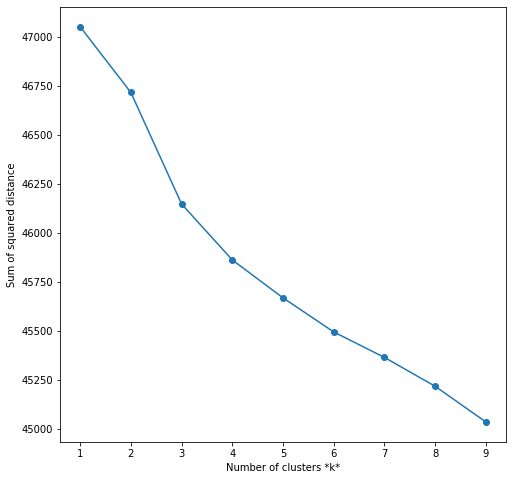

In [12]:
# Demonstarting the ELBOW for selecting the correct "K" value in k-means algorithm.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, n_init=5)
    km.fit(data_tfidf)
    sse.append(km.inertia_)

# Plot sse against k  
plt.figure(figsize=(8, 8))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');   
plt.show()

In [7]:
# Function for Dimensional reduction using PCA, TruncatedSVD()

def reduce_dimensions(data):
    pca = TruncatedSVD(n_components=100)
    vec_matrix_pca = pca.fit_transform(data)
    return vec_matrix_pca

data_idf_matrix = reduce_dimensions(data_tfidf)

## 2) Function to cluster all documents and assign a cluster id to each document.
* First we have loaded the data and pre processed the text data using various nlp preprocessing techniques used in step 1
* We are feeding the data to Data TF-IDF to create a sparse matrix
* Then we have done the __ELBOW__ method to find the best __K__ value for k means clustering.
* We have selected value of K as 6 because we can deduce from the elbow that the curbe starts to bend less where number of clusters is 6.
*  __Reasons for using k-means__ - As we will see in step 3, k-means generalizes our clusters to different shapes and sizes i.e, elleptical clusters. It is easy to implement and guarentees convergences. As our dataset is relatively large k-means scales to large datasets.

In [21]:
# Function to cluster all the documents and assign the cluster id

def create_clusters(data, newsgroup):
    clusters = KMeans(n_clusters=6, n_init=10)
    clusters.fit(data)
    newsgroup['cluster_id'] = clusters.labels_
    labels = clusters.labels_
    return newsgroup, labels

# Newsgroup_df with cluster_ids
newsgroup_df,labels = create_clusters(data_idf_matrix,newsgroup_df)
newsgroup_df.head()

,headline,text,bip_topics,date_published,itemid,filename,cluster_id
0,OFFICIAL JOURNAL CONTENTS - OJ L 66 OF MARCH 6...,"[council, regul, ec, decemb, fix, certain, fis...",G15,1997-03-10,429411,429411newsML.xml,4
1,OFFICIAL JOURNAL CONTENTS - OJ C 74 OF MARCH 8...,"[note, content, display, revers, order, print,...",G15,1997-03-10,429412,429412newsML.xml,4
2,OFFICIAL JOURNAL CONTENTS - OJ C 73 OF MARCH 8...,"[note, content, display, revers, order, print,...",G15,1997-03-10,429413,429413newsML.xml,4
3,OFFICIAL JOURNAL CONTENTS - OJ L 68 OF MARCH 8...,"[note, content, display, revers, order, print,...",G15,1997-03-10,429414,429414newsML.xml,4
4,Canada provincial T-bill auction results - Man...,"[date, prov, mat, c, amt, avg, chg, price, hi,...",M13,1997-03-10,429415,429415newsML.xml,4


In [24]:
# creating different dataframes for different cluster so that we can classify each cluster

cluster0 = newsgroup_df.loc[newsgroup_df['cluster_id'] == 0].reset_index(drop=True)
cluster1 = newsgroup_df.loc[newsgroup_df['cluster_id'] == 1].reset_index(drop=True)
cluster2 = newsgroup_df.loc[newsgroup_df['cluster_id'] == 2].reset_index(drop=True)
cluster3 = newsgroup_df.loc[newsgroup_df['cluster_id'] == 3].reset_index(drop=True)
cluster4 = newsgroup_df.loc[newsgroup_df['cluster_id'] == 4].reset_index(drop=True)
cluster5 = newsgroup_df.loc[newsgroup_df['cluster_id'] == 5].reset_index(drop=True)

In [25]:
def hold_out_set(data_tfidf,newsgroup_taget):
    X_train, X_test, y_train, y_test = train_test_split(data_tfidf, newsgroup_taget, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

### Generating classifier for each identified cluster
I have used two classifications models for classifying each clusters namely:-
* __SVM__ <br>
* __Random Forest__

#### Reason for Using SVM
>  For text classification of single class, svm classifier offers __good accuracy__ and __faster predictions__ than any other text classifiers such as naives bayes. They are generally faster because they __use less memory__ as they only uses subset of training point in decision phase. Another reason why I have choosed SVM is they offers __clear margin of separation__ and with high dimensional space.

In [40]:
# svm.SVC() classifier
# Calling the functions to classify documents in each cluster

def classifier_svm(X_train, X_test, y_train, y_test):
    svm_clf = svm.SVC(kernel='linear')
    svm_clf.fit(X_train, y_train) 
    predicted_svm_linear = svm_clf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted_svm_linear)
    f1_scores = f1_score(y_test, predicted_svm_linear,average='micro')
    print("Accuracy of SVM :- ", accuracy)
    print("F1 Score of SVM :- ", f1_scores)
    return accuracy

#### Reason for Using Random Forest
> I have used Random forest for __higher dimensional clusters__ below. This is because the random forest is a bagging technique based on weak learners and thus they are __faster to train__. They are also hghly __resistant to instability__ i.e, if the data changes a bit it can affect a single tree but the overall outcome of forest remain same. The second reason for using random forest is it __generates an internal unbiased estimate of generalization error__ as the forest building progesses. It also provides methods for __balancing error in class population and unbalanced set__. It is also __fully parallizable__ although I have not used GPU.

In [41]:
# Random Forest Clasifier
def classifier_random_forest(X_train, X_test, y_train, y_test):
    clf=RandomForestClassifier(n_estimators = 10)
    clf.fit(X_train,y_train)
    y_predicted=clf.predict(X_test)
    accuracy = accuracy_score(y_true = y_test, y_pred = y_predicted)
    f1_scores = f1_score(y_test, y_predicted,average='micro')
    print("Accuracy of random forest :- ", accuracy)
    print("F1 Score random forest :- ", f1_score(y_test, y_predicted,average='micro'))
    return accuracy

#### Classifying each clusters with SVM and RandomForest

In [42]:
data_tfidf0 = extract_features(cluster0)
newsgroup_taget0 = label_encoder(cluster0)

print("TFIDF shape :- ", data_tfidf0.shape)
print('Label encoded target data shape:- ', newsgroup_taget0.shape)
X_train, X_test, y_train, y_test = hold_out_set(data_tfidf0,newsgroup_taget0)
accuracy_cluster0 = classifier_svm(X_train, X_test, y_train, y_test)

TFIDF shape :-  (524, 1357)
Label encoded target data shape:-  (524,)
Accuracy of SVM :-  0.9936708860759493
F1 Score of SVM :-  0.9936708860759493


In [43]:
data_tfidf1 = extract_features(cluster1)
newsgroup_taget1 = label_encoder(cluster1)
print("TFIDF shape :- ", data_tfidf1.shape)
print('Label encoded target data shape:- ', newsgroup_taget1.shape)
X_train, X_test, y_train, y_test = hold_out_set(data_tfidf1,newsgroup_taget1)
accuracy_cluster1 = classifier_svm(X_train, X_test, y_train, y_test)

TFIDF shape :-  (3244, 10578)
Label encoded target data shape:-  (3244,)
Accuracy of SVM :-  0.8357289527720739
F1 Score of SVM :-  0.8357289527720738


In [44]:
data_tfidf2 = extract_features(cluster2)
newsgroup_taget2 = label_encoder(cluster2)
print("TFIDF shape :- ", data_tfidf2.shape)
print('Label encoded target data shape:- ', newsgroup_taget2.shape)
X_train, X_test, y_train, y_test = hold_out_set(data_tfidf2,newsgroup_taget2)
accuracy_cluster2 = classifier_svm(X_train, X_test, y_train, y_test)

TFIDF shape :-  (1354, 3970)
Label encoded target data shape:-  (1354,)
Accuracy of SVM :-  0.972972972972973
F1 Score of SVM :-  0.972972972972973


In [45]:
data_tfidf3 = extract_features(cluster3)
newsgroup_taget3 = label_encoder(cluster3)
print("TFIDF shape :- ", data_tfidf3.shape)
print('Label encoded target data shape:- ', newsgroup_taget3.shape)
X_train, X_test, y_train, y_test = hold_out_set(data_tfidf3,newsgroup_taget3)
accuracy_cluster3 = classifier_svm(X_train, X_test, y_train, y_test)

TFIDF shape :-  (1097, 2361)
Label encoded target data shape:-  (1097,)
Accuracy of SVM :-  0.996969696969697
F1 Score of SVM :-  0.996969696969697


In [46]:
data_tfidf4 = extract_features(cluster4)
newsgroup_taget4 = label_encoder(cluster4)
print("TFIDF shape :- ", data_tfidf4.shape)
print('Label encoded target data shape:- ', newsgroup_taget4.shape)
X_train, X_test, y_train, y_test = hold_out_set(data_tfidf4,newsgroup_taget4)
accuracy_cluster4 = classifier_random_forest(X_train, X_test, y_train, y_test)

TFIDF shape :-  (30497, 20000)
Label encoded target data shape:-  (30497,)
Accuracy of random forest :-  0.653551912568306
F1 Score random forest :-  0.653551912568306


In [47]:
data_tfidf5 = extract_features(cluster5)
newsgroup_taget5 = label_encoder(cluster5)
print("TFIDF shape :- ", data_tfidf5.shape)
print('Label encoded target data shape:- ', newsgroup_taget5.shape)
X_train, X_test, y_train, y_test = hold_out_set(data_tfidf5,newsgroup_taget5)
accuracy_cluster5 = classifier_random_forest(X_train, X_test, y_train  , y_test)

TFIDF shape :-  (11542, 20000)
Label encoded target data shape:-  (11542,)
Accuracy of random forest :-  0.6459717008374242
F1 Score random forest :-  0.6459717008374242


## (3) Function to evaluate the quality of clusters using shilloutte
> I have two kind of evaluation statergies i.e,
    <br> __Internal Evaluation__ - Clustering data is evaluated based on data that was cluster itself.
    <br> __External Evaluation__ - Clustering data is evaluated based on data that was not used for clustering such as class labels and external benchmarks.

- __In this step I have tried to plot all the silhoutte diagram and k means sampling from the range (2,6). This is direct implementation given is scikit library.__

For n_clusters = 2 The average silhouette_score is : 0.12700562796376524
For n_clusters = 3 The average silhouette_score is : 0.1020879156394196
For n_clusters = 4 The average silhouette_score is : 0.1025733915143742
For n_clusters = 5 The average silhouette_score is : 0.10835659034756641
For n_clusters = 6 The average silhouette_score is : 0.10564568109859142


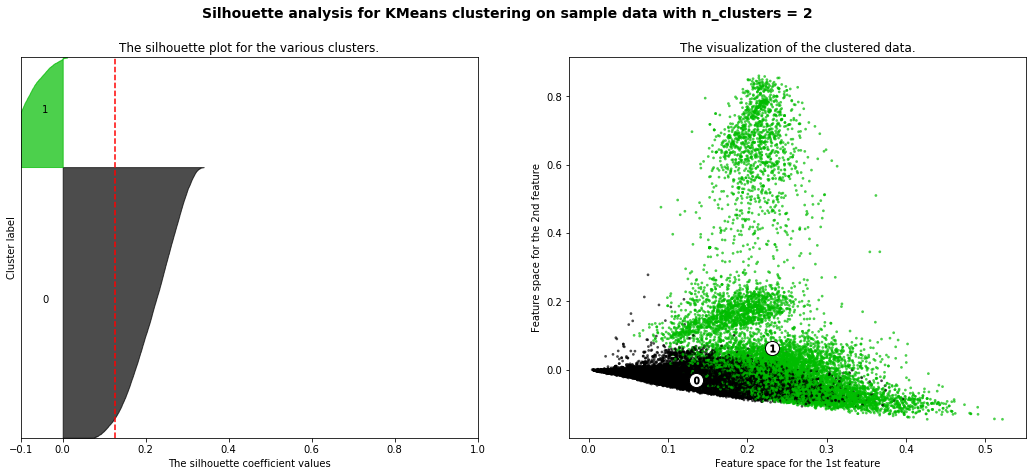

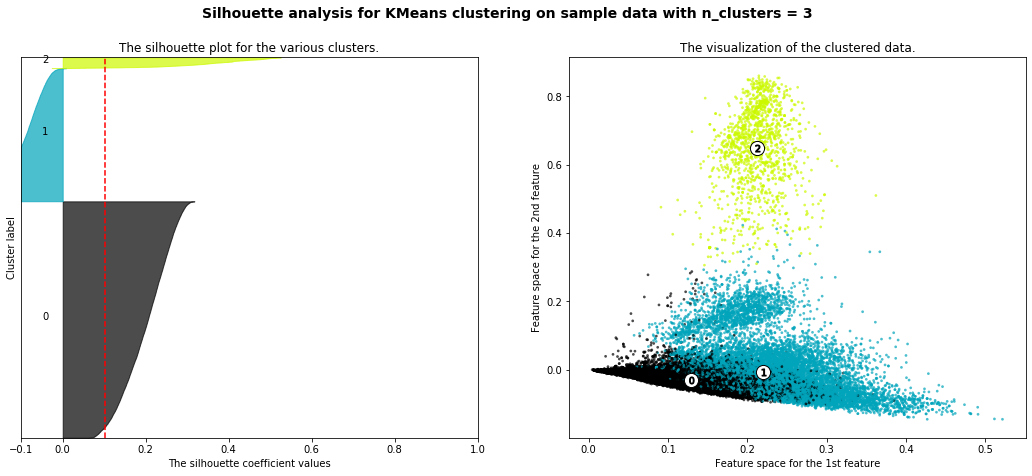

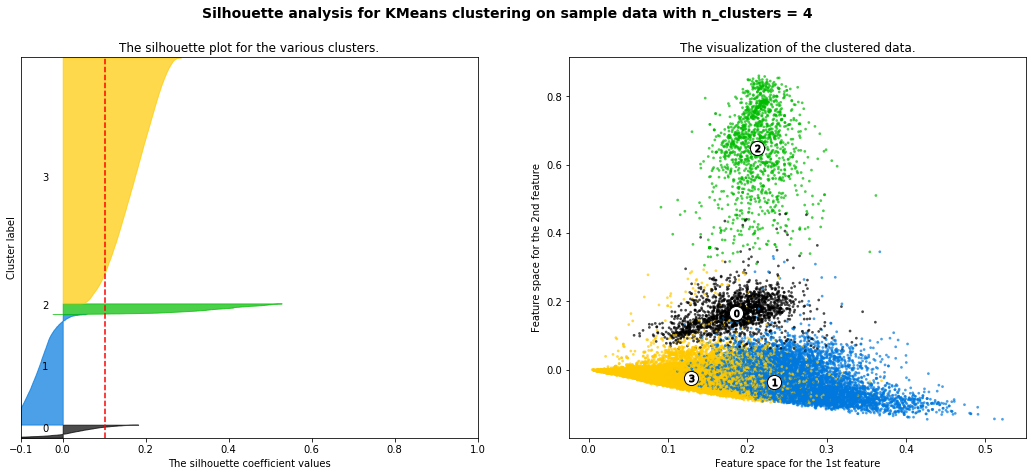

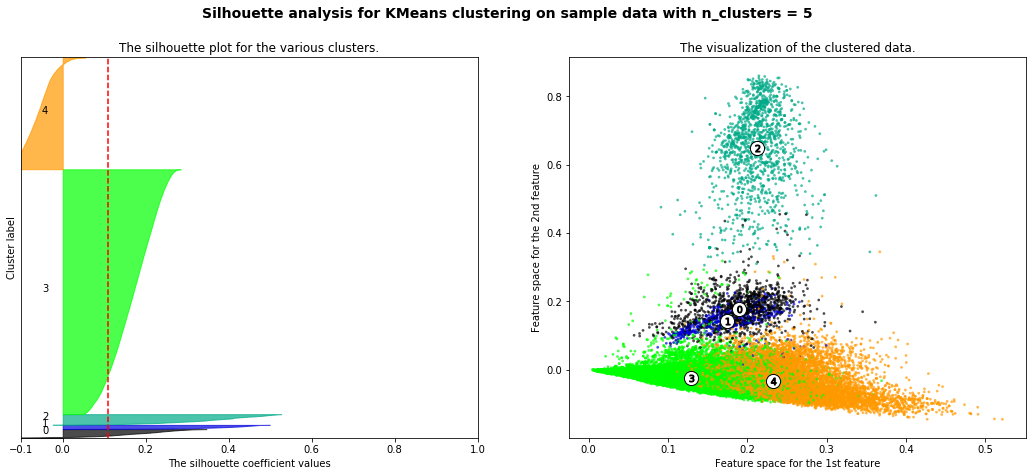

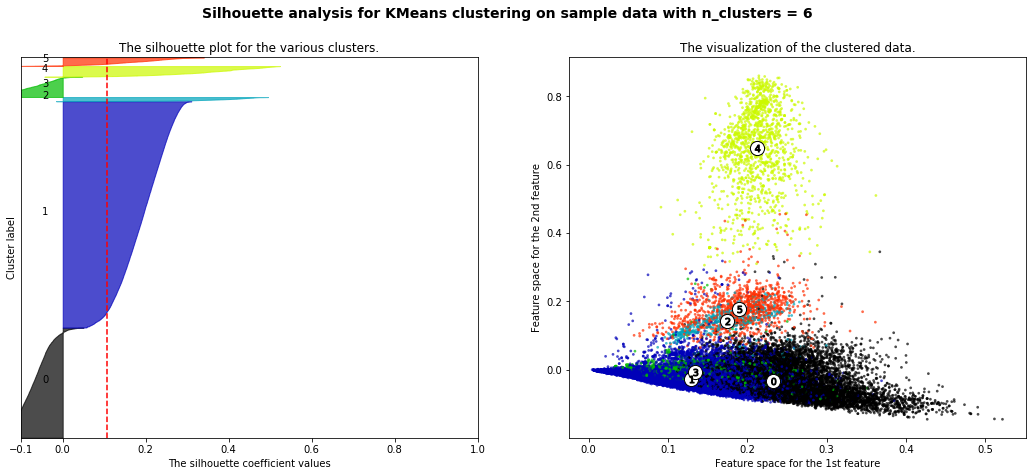

In [8]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(data_idf_matrix) + (n_clusters + 1) * 10])


    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_idf_matrix)


    silhouette_avg = silhouette_score(data_idf_matrix, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(data_idf_matrix, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_idf_matrix[:, 0], data_idf_matrix[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Intrinsic Evaluation

-  __Silhouette_score__ -  I have directly calculated the silhoutte on our data which was converted in tf-idf matrix and the labels assigned after clustering. Silhoutte score can range from (-1,1) where scores are higher towards 1 when cluster are dense and separated. In our case we got an __silhoutte of 0.113__ which signifies the few clusters are dense and well separated and few are overlapping with other clusters.

- __Daves Bouldin Score__ - I have computed daves bouldin index as the it is faster to implement than silhoutte and it computes the index of only quantities and features, inherent to our dataset. The best possible value is close to zero. In our case we got an value of __2.72__ which says that there are few overlapping clusters.

In [48]:
# Assigning the labels first and then finding the silhouette score

metrics.silhouette_score(data_idf_matrix, labels, metric='euclidean')

0.11319510355398887

In [49]:
# Davies-Bouldin Index

from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(data_idf_matrix, labels)

2.7207061370996435

### Extrinsic Evaluation
I ahve used calinski harabasz score to calculate the external evaluation of cluster. Our score is higher which suggests few clusters are dense and well separated.

In [50]:
# Calinski-Harabasz Index

metrics.calinski_harabasz_score(data_idf_matrix, labels)

1832.5628248845637

## (4) Extracting features for each cluster with Auto-Encoders
> I have built an autoencoder as suggested in paper 1 for feature extraction. I have used relu as the activation function for the encoder and decoder. The optimizer I have used is adam and the loss function is binary crossentropy. My get_cluster_features_autoencoders() accepts two parameters i.e, each cluster data and then the target label for that cluster. Then I am training the autoencoder to minimize the loss with epochs as 3. Finally I have taken enchancing the feature selection by taking the result of last encoded layer i.e, encoder3 as our extracted features.

In [122]:
# Auto encoder function to extract/select features for each cluster as suggested in the paper 1

def get_cluster_features_autoencoders(data_tfidf,newsgroup_taget):    
    ncol = data_tfidf.shape[1] # gives us the total number of features to train on
    input_dim = Input(shape = (ncol, ))
    encoding_dim = 1000  # Gives us the number of features in each clustetr to extract
 
    # Encoder Layers
    encoded1 = Dense(5000, activation = 'relu')(input_dim)
    encoded2 = Dense(3500, activation = 'relu')(encoded1)
    encoded3 = Dense(encoding_dim, activation = 'relu')(encoded2)

    # Decoder Layers
    decoded1 = Dense(3500, activation = 'relu')(encoded3)
    decoded2 = Dense(5000, activation = 'relu')(decoded1)
    decoded3 = Dense(ncol, activation = 'sigmoid')(decoded2)
    
    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded3)

    # Compile the Model
    autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    
    #Model Summary
    autoencoder.summary()
    
    #dividing into training and testing set by calling our previously defined function
    X_train, X_test, y_train, y_test = hold_out_set(data_tfidf,newsgroup_taget)
    
    # to find the total information loss in autoencoder
    autoencoder.fit(X_train, X_train, epochs = 3, batch_size = 128, shuffle = False, validation_data = (X_test, X_test))
    
    # FOR EXTRACTING FEATURES WE NEED THE LAST ENCODER LAYER i.e, ENCODER3 as asked in our question
    encoder = Model(inputs = input_dim, outputs = encoded3)
    encoded_input = Input(shape = (encoding_dim, ))
    
    # Generating the set of features
    encoded_features = encoder.predict(data_tfidf)
    
    #returning the generated set of features
    return encoded_features

#### Calling get_cluster_features_autoencoders() on each clusters to select the best features in each cluster.

In [123]:
# SELECTING FEATURES FOR CLSUTER 0

features_selected_cluster0 = get_cluster_features_autoencoders(data_tfidf0,newsgroup_taget0)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1357)]            0         
_________________________________________________________________
dense_30 (Dense)             (None, 5000)              6790000   
_________________________________________________________________
dense_31 (Dense)             (None, 3500)              17503500  
_________________________________________________________________
dense_32 (Dense)             (None, 1000)              3501000   
_________________________________________________________________
dense_33 (Dense)             (None, 3500)              3503500   
_________________________________________________________________
dense_34 (Dense)             (None, 5000)              17505000  
_________________________________________________________________
dense_35 (Dense)             (None, 1357)              6786

In [139]:
# SELECTING FEATURES FOR CLSUTER 1

features_selected_cluster1 = get_cluster_features_autoencoders(data_tfidf1,newsgroup_taget1)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 10578)]           0         
_________________________________________________________________
dense_40 (Dense)             (None, 5000)              52895000  
_________________________________________________________________
dense_41 (Dense)             (None, 3500)              17503500  
_________________________________________________________________
dense_42 (Dense)             (None, 1000)              3501000   
_________________________________________________________________
dense_43 (Dense)             (None, 3500)              3503500   
_________________________________________________________________
dense_44 (Dense)             (None, 5000)              17505000  
_________________________________________________________________
dense_45 (Dense)             (None, 10578)             5290

In [140]:
# SELECTING FEATURES FOR CLSUTER 2

features_selected_cluster2 = get_cluster_features_autoencoders(data_tfidf2,newsgroup_taget2)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3970)]            0         
_________________________________________________________________
dense_46 (Dense)             (None, 5000)              19855000  
_________________________________________________________________
dense_47 (Dense)             (None, 3500)              17503500  
_________________________________________________________________
dense_48 (Dense)             (None, 1000)              3501000   
_________________________________________________________________
dense_49 (Dense)             (None, 3500)              3503500   
_________________________________________________________________
dense_50 (Dense)             (None, 5000)              17505000  
_________________________________________________________________
dense_51 (Dense)             (None, 3970)              198

In [141]:
# SELECTING FEATURES FOR CLSUTER 3

features_selected_cluster3 = get_cluster_features_autoencoders(data_tfidf3,newsgroup_taget3)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2361)]            0         
_________________________________________________________________
dense_52 (Dense)             (None, 5000)              11810000  
_________________________________________________________________
dense_53 (Dense)             (None, 3500)              17503500  
_________________________________________________________________
dense_54 (Dense)             (None, 1000)              3501000   
_________________________________________________________________
dense_55 (Dense)             (None, 3500)              3503500   
_________________________________________________________________
dense_56 (Dense)             (None, 5000)              17505000  
_________________________________________________________________
dense_57 (Dense)             (None, 2361)              118

In [142]:
# SELECTING FEATURES FOR CLSUTER 4

features_selected_cluster4 = get_cluster_features_autoencoders(data_tfidf4,newsgroup_taget4)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 20000)]           0         
_________________________________________________________________
dense_58 (Dense)             (None, 5000)              100005000 
_________________________________________________________________
dense_59 (Dense)             (None, 3500)              17503500  
_________________________________________________________________
dense_60 (Dense)             (None, 1000)              3501000   
_________________________________________________________________
dense_61 (Dense)             (None, 3500)              3503500   
_________________________________________________________________
dense_62 (Dense)             (None, 5000)              17505000  
_________________________________________________________________
dense_63 (Dense)             (None, 20000)             100

In [143]:
# SELECTING FEATURES FOR CLSUTER 5

features_selected_cluster5 = get_cluster_features_autoencoders(data_tfidf5,newsgroup_taget5)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 20000)]           0         
_________________________________________________________________
dense_64 (Dense)             (None, 5000)              100005000 
_________________________________________________________________
dense_65 (Dense)             (None, 3500)              17503500  
_________________________________________________________________
dense_66 (Dense)             (None, 1000)              3501000   
_________________________________________________________________
dense_67 (Dense)             (None, 3500)              3503500   
_________________________________________________________________
dense_68 (Dense)             (None, 5000)              17505000  
_________________________________________________________________
dense_69 (Dense)             (None, 20000)             100

## (5) Forming deep nural network  with the extracte features in step 4
> I am using a function called get_deep_neural_network() which accepts the selected features and target for every cluster. 
Here the target column is one hot encoded.I am building a deep neural network by forming a sequential model. The hyperparameters I have used in this are activation as relu and sigmoid, loss as binary_crossentropy(as it is a binary classification) and metrics as accuracy.<br><br>
> __Changes from Assignment1__  - I have preprocessed the data in a more better way compared to assignment 1. For neural network I have one hot encoded the target column when compared to label encoder in assignment 1. I have also made sure the feature selections gets the best features in the set in our project while in my last assignment I have selected features arbitarily.<br><br>
__Because of these changes I am getting more than 95% accuracy in both training and testing set in all clusters. This shows the classfication process has improved. We can verify the same by the accuracy diagram in the end.__

In [161]:
# Function for deep neural network
# This function gets the selected features and target

def get_deep_neural_network(selected_features, selected_target):
    X_train, X_test, y_train, y_test = hold_out_set(selected_features,selected_target)
    
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1] # Number of output features
    
    model = Sequential()
    model.add(layers.Dense(500, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(output_dim, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    history = model.fit(X_train, y_train,epochs=5,verbose=True,validation_data=(X_test, y_test),batch_size=64)
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("###########################################")
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    return accuracy

#### Calling the get_deep_neural_network() on each cluster to classify the target correctly.

In [162]:
# Cluster 0 prediction with deep neural network on extracted features in step 4

newsgroup_taget0 = one_hot_encoder(cluster0) # using one hot encoder for target variable

NN_accuracy_cluster0 = get_deep_neural_network(features_selected_cluster0, newsgroup_taget0) # storing the accuracy

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_85 (Dense)             (None, 4)                 2004      
Total params: 502,504
Trainable params: 502,504
Non-trainable params: 0
_________________________________________________________________
Train on 366 samples, validate on 158 samples
Epoch 1/5
366/366 [==============================] - 13s 35ms/sample - loss: 0.4176 - accuracy: 0.8607 - val_loss: 0.0331 - val_accuracy: 0.9968
Epoch 2/5
366/366 [==============================] - 0s 203us/sample - loss: 0.0985 - accuracy: 0.9918 - val_loss: 0.0414 - val_accuracy: 0.9968
Epoch 3/5
366/366 [==============================] - 0s 185us/sample - loss: 0.0968 - accuracy: 0.9918 - val_loss: 0.0489 - val_accuracy: 0.9968
Epoch 4/5
366/366 [=========

In [163]:
# Cluster 1 prediction with deep neural network on extracted features in step 4

newsgroup_taget1 = one_hot_encoder(cluster1) # using one hot encoder for target variable

NN_accuracy_cluster1 = get_deep_neural_network(features_selected_cluster1, newsgroup_taget1) # storing the accuracy

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_87 (Dense)             (None, 24)                12024     
Total params: 512,524
Trainable params: 512,524
Non-trainable params: 0
_________________________________________________________________
Train on 2270 samples, validate on 974 samples
Epoch 1/5
2270/2270 [==============================] - 1s 340us/sample - loss: 0.9708 - accuracy: 0.9504 - val_loss: 0.3006 - val_accuracy: 0.9756
Epoch 2/5
2270/2270 [==============================] - 0s 118us/sample - loss: 0.3832 - accuracy: 0.9646 - val_loss: 0.3444 - val_accuracy: 0.9756
Epoch 3/5
2270/2270 [==============================] - 0s 112us/sample - loss: 0.2989 - accuracy: 0.9651 - val_loss: 0.3037 - val_accuracy: 0.9583
Epoch 4/5
2270/2270 [

In [164]:
# Cluster 2 prediction with deep neural network on extracted features in step 4

newsgroup_taget2 = one_hot_encoder(cluster2) # using one hot encoder for target variable

NN_accuracy_cluster2 = get_deep_neural_network(features_selected_cluster2, newsgroup_taget2) # storing the accuracy

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_89 (Dense)             (None, 11)                5511      
Total params: 506,011
Trainable params: 506,011
Non-trainable params: 0
_________________________________________________________________
Train on 947 samples, validate on 407 samples
Epoch 1/5
947/947 [==============================] - 1s 557us/sample - loss: 0.3145 - accuracy: 0.9683 - val_loss: 0.1053 - val_accuracy: 0.9920
Epoch 2/5
947/947 [==============================] - 0s 120us/sample - loss: 0.1477 - accuracy: 0.9929 - val_loss: 0.1385 - val_accuracy: 0.9920
Epoch 3/5
947/947 [==============================] - 0s 116us/sample - loss: 0.1558 - accuracy: 0.9845 - val_loss: 0.1708 - val_accuracy: 0.9920
Epoch 4/5
947/947 [=========

In [165]:
# Cluster 3 prediction with deep neural network on extracted features in step 4

newsgroup_taget3 = one_hot_encoder(cluster3) # using one hot encoder for target variable

NN_accuracy_cluster3 = get_deep_neural_network(features_selected_cluster3, newsgroup_taget3) # storing the accuracy

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_91 (Dense)             (None, 4)                 2004      
Total params: 502,504
Trainable params: 502,504
Non-trainable params: 0
_________________________________________________________________
Train on 767 samples, validate on 330 samples
Epoch 1/5
767/767 [==============================] - 1s 678us/sample - loss: 0.5844 - accuracy: 0.9355 - val_loss: 0.0949 - val_accuracy: 0.9985
Epoch 2/5
767/767 [==============================] - 0s 131us/sample - loss: 0.1132 - accuracy: 0.9980 - val_loss: 0.1150 - val_accuracy: 0.9985
Epoch 3/5
767/767 [==============================] - 0s 117us/sample - loss: 0.1234 - accuracy: 0.9980 - val_loss: 0.1241 - val_accuracy: 0.9985
Epoch 4/5
767/767 [=========

In [166]:
# Cluster 4 prediction with deep neural network on extracted features in step 4

newsgroup_taget4 = one_hot_encoder(cluster4) # using one hot encoder for target variable

NN_accuracy_cluster4 = get_deep_neural_network(features_selected_cluster4, newsgroup_taget4) # storing the accuracy

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_93 (Dense)             (None, 66)                33066     
Total params: 533,566
Trainable params: 533,566
Non-trainable params: 0
_________________________________________________________________
Train on 21347 samples, validate on 9150 samples
Epoch 1/5
21347/21347 [==============================] - 3s 126us/sample - loss: 0.1650 - accuracy: 0.9793 - val_loss: 0.1138 - val_accuracy: 0.9797
Epoch 2/5
21347/21347 [==============================] - 2s 107us/sample - loss: 0.0824 - accuracy: 0.9827 - val_loss: 0.0790 - val_accuracy: 0.9848
Epoch 3/5
21347/21347 [==============================] - 2s 106us/sample - loss: 0.0681 - accuracy: 0.9834 - val_loss: 0.0618 - val_accuracy: 0.9848
Epoch 4/5
213

In [167]:
# Cluster 5 prediction with deep neural network on extracted features in step 4

newsgroup_taget5 = one_hot_encoder(cluster5) # using one hot encoder for target variable

NN_accuracy_cluster5 = get_deep_neural_network(features_selected_cluster5, newsgroup_taget5) # storing the accuracy

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_95 (Dense)             (None, 56)                28056     
Total params: 528,556
Trainable params: 528,556
Non-trainable params: 0
_________________________________________________________________
Train on 8079 samples, validate on 3463 samples
Epoch 1/5
8079/8079 [==============================] - 1s 150us/sample - loss: 0.2894 - accuracy: 0.9716 - val_loss: 0.1591 - val_accuracy: 0.9706
Epoch 2/5
8079/8079 [==============================] - 1s 108us/sample - loss: 0.1506 - accuracy: 0.9744 - val_loss: 0.1244 - val_accuracy: 0.9583
Epoch 3/5
8079/8079 [==============================] - 1s 106us/sample - loss: 0.1162 - accuracy: 0.9765 - val_loss: 0.0996 - val_accuracy: 0.9821
Epoch 4/5
8079/8079 

### By Visualization proving that our deep neural networks improves the classification approach

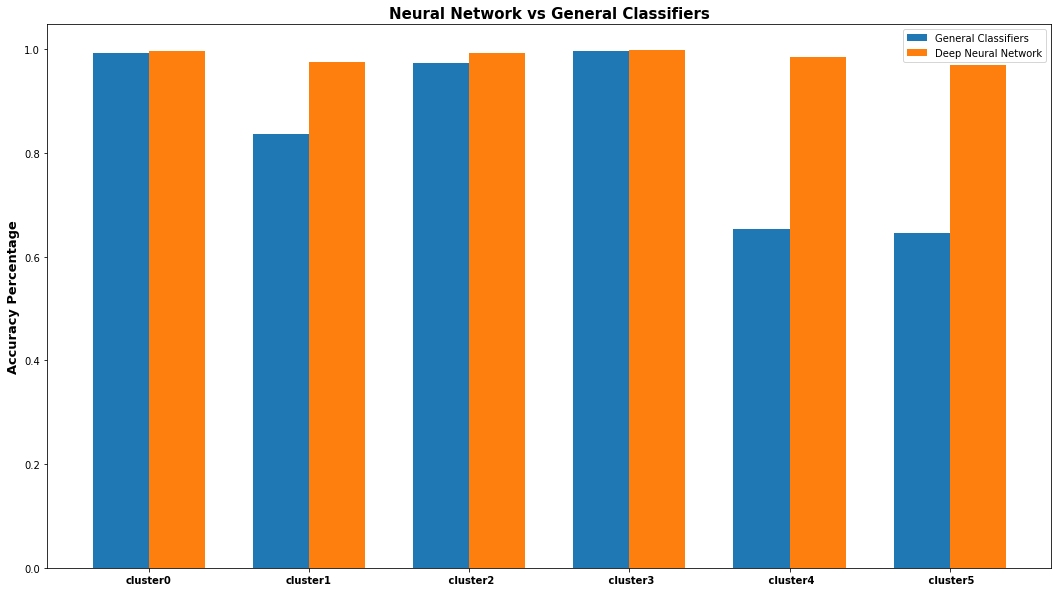

In [176]:
#compare the accuracy and average_class accuracy for each algorithm 

no_of_clusters = 6
normal_classifier_accuracy = [accuracy_cluster0, accuracy_cluster1, accuracy_cluster2,accuracy_cluster3,
                              accuracy_cluster4,accuracy_cluster5]
deep_nural_network_accuracy = [NN_accuracy_cluster0, NN_accuracy_cluster1, NN_accuracy_cluster2,
                               NN_accuracy_cluster3,NN_accuracy_cluster4,NN_accuracy_cluster5]

no = np.arange(no_of_clusters) 
width = 0.35       
plt.figure(figsize=(18,10))
plt.bar(no, normal_classifier_accuracy, width, label='General Classifiers')
plt.bar(no + width, deep_nural_network_accuracy, width, label='Deep Neural Network')
plt.title('Neural Network vs General Classifiers',fontsize=15,fontweight='bold')
plt.xticks(no + width / 2, ('cluster0','cluster1',' cluster2',' cluster3',' cluster4',' cluster5'),fontweight='bold')
plt.ylabel("Accuracy Percentage",fontweight='bold',fontsize=13)
plt.legend(loc='best')
plt.show()

## REFERENCES :- 

[1] I have recieved TA's help (Mohammad Etemad) for better understanding and clarity of problem statements in the project.<br><br>
[2]"2.3. Clustering — scikit-learn 0.22 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation. [Accessed: 13- Dec- 2019].<br><br>
[3]"Selecting the number of clusters with silhouette analysis on KMeans clustering — scikit-learn 0.22 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html. [Accessed: 13- Dec- 2019].<br><br>
[4]"Applied Deep Learning - Part 3: Autoencoders", Medium, 2019. [Online]. Available: https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798. [Accessed: 13- Dec- 2019].<br><br>
[5]"Deep inside: Autoencoders", Medium, 2019. [Online]. Available: https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f. [Accessed: 13- Dec- 2019].<br><br>
[6]"2.3. Clustering — scikit-learn 0.22 documentation", Scikit-learn.org, 2019. [Online]. Available: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation. [Accessed: 13- Dec- 2019].<br><br>
[7]"Cluster analysis", En.wikipedia.org, 2019. [Online]. Available: https://en.wikipedia.org/wiki/Cluster_analysis. [Accessed: 13- Dec- 2019].<br><br>
[8]"Support Vector Machines in Scikit-learn", DataCamp Community, 2019. [Online]. Available: https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python. [Accessed: 13- Dec- 2019].<br><br>
[9]"Random Forests Classifiers in Python", DataCamp Community, 2019. [Online]. Available: https://www.datacamp.com/community/tutorials/random-forests-classifier-python. [Accessed: 13- Dec- 2019].<br><br>
[10]"k-Means Advantages and Disadvantages  |  Clustering in Machine Learning", Google Developers, 2019. [Online]. Available: https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages. [Accessed: 13- Dec- 2019].<br><br>
[11]"Machine Learning, NLP: Text Classification using scikit-learn, python and NLTK.", Medium, 2019. [Online]. Available: https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a. [Accessed: 17- Jul- 2019].
<br>
<br>
[12]"Python Machine Learning By Example", Google Books, 2019. [Online]. Available: https://books.google.ca/books?id=0nc5DwAAQBAJ&pg=PA53&lpg=PA53&dq=fetch_20newsgroups+cleaned&source=bl&ots=RZ2-EIARio&sig=ACfU3U37jIBWFGtayvQrIY4FoSM_dQW6Vw&hl=en&sa=X&ved=2ahUKEwjlysHRn7DjAhXEJt8KHS6xBm8Q6AEwBnoECAoQAQ#v=
onepage&q&f=false. [Accessed: 17- Jul- 2019].
<br>
<br>
[13]"re — Regular expression operations — Python 3.7.4 documentation", Docs.python.org, 2019. [Online]. Available: https://docs.python.org/3/library/re.html. [Accessed: 17- Jul- 2019].
<br>
<br>
[14]"Why Random Forest is My Favorite Machine Learning Model", Medium, 2019. [Online]. Available: https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706. 
<br>
<br>